In [2]:
import skimage
import os
from cellpose import models
import numpy as np
from aicsimageio import AICSImage
import tifffile
import napari
import time
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import apoc
from IPython.display import clear_output
from scipy.spatial import distance
scen_channel = 0
marker_channel = 1
nuclei_channel = 2

#padding to extract around each scenescent cell
x_pad = 50
y_pad = 50

#3D classifier
cl3D_filename = 'models/scen_3D.cl'

In [3]:

def ExtractSingleObject(image, centroid, x_pad = 50, y_pad = 50):
    cy = int(centroid[0])
    cx = int(centroid[1])

    subset_im = np.copy(image[cy-y_pad:cy+y_pad, cx-x_pad:cx+x_pad])
    return subset_im

def ExtractSingleObject3D(image, centroid, x_pad = 50, y_pad = 50):
    cy = int(centroid[0])
    cx = int(centroid[1])
    subset_im = np.copy(image[:, cy-y_pad:cy+y_pad, cx-x_pad:cx+x_pad])
    return subset_im

def filter_classified_image(im, lower_bound, upper_bound):
    '''takes a  label image, an upper and lower size bound and returns a labeled image conatining only the objects within that size bound'''
    props = skimage.measure.regionprops(im)
    for prop in tqdm(props, desc="Filtering senescent cell regions"):
        if prop['area'] < (lower_bound):
            im[im == prop['label']] = 0
        if prop['area'] > (upper_bound):
            im[im == prop['label']] = 0

    return im

def match_nuclei_3D():
    print('implement')

def MatchNuclei(scen_mask_im, nuc_mask_im):
    props_scen = skimage.measure.regionprops(scen_mask_im)
    scen_labels_updated = np.copy(scen_mask_im)
    scen_labels_matched = np.zeros(scen_mask_im.shape, dtype=np.uint16)
    matching_nuclei = np.zeros(nuc_mask_im.shape, dtype=np.uint16)
    
    for i, prop in enumerate(tqdm(props_scen, desc="Matching nuclei to senescent cell masks")): 

        num_nuc = 0  #keep track of the number of nuclei per senescent cell
        matched_nuc_val = -1   #keep track of the matching nuclear value
        
        single_scen_im = ExtractSingleObject(scen_mask_im, prop['centroid'])
        single_scen_im[single_scen_im != prop['label']] = 0

        single_nuc_im = ExtractSingleObject(nuc_mask_im, prop['centroid'])
        matched_nuclei = np.copy(single_nuc_im)

        matched_nuclei[single_scen_im != prop['label']] = 0
        unique, counts = np.unique(matched_nuclei, return_counts=True)
        
        max_count = 0
        max_nuc = -1
        for unique, count in zip(unique, counts):
            if unique > 0:
                if count > max_count:
                    max_count = count     
                    max_nuc = unique

            if max_nuc > -1:
                nuc_total_area = np.count_nonzero(nuc_mask_im[nuc_mask_im == max_nuc])
                overlap = max_count / nuc_total_area * 100
                if overlap > 80:
                    matching_nuclei[nuc_mask_im == max_nuc] = max_nuc
                    scen_labels_updated[scen_mask_im == prop['label']] = 0
                    scen_labels_matched[scen_mask_im == prop['label']] = prop['label']
    return matching_nuclei, scen_labels_updated, scen_labels_matched

def MakeChullImage(lab_im):
    chull_image = np.zeros(lab_im.shape)
    props = skimage.measure.regionprops(lab_im)

    for prop in tqdm(props, desc="Calculating convex hull image"):
        temp = np.zeros(lab_im.shape)
        subset_im = ExtractSingleObject(lab_im, prop['centroid'])
        subset_im[subset_im != prop['label']] = 0
        cy = int(prop['centroid'][0])
        cx = int(prop['centroid'][1])
        chull = skimage.morphology.convex_hull_image(subset_im)
        try:        
            temp[cy-150:cy+150, cx-150:cx+150] = chull
            chull_image[temp > 0] = prop['label']
        except:
            print('chull failed')
    return chull_image.astype(np.uint16)

def find_max_overlap(nuc_mask_subset, clean_scen_labs, min_overlap = 0.2):
    '''takes a celpose classified 3D nuclear mask image, and a scenescent label image with a single 
    label, and finds the corresponding nucleus based on maximum overlap
    returns nucleus label, nucleus centroid and overlap amount
    '''
    nuc_props = skimage.measure.regionprops(nuc_mask_subset)
    max_overlap = 0
    max_lab = - 1
    nuc_centroid = -1
    for nuc_prop in nuc_props:
        nuc_area = nuc_prop['area']
        overlap = np.count_nonzero(clean_scen_labs[nuc_mask_subset == nuc_prop['label']])
        if (overlap / nuc_area) > min_overlap:
            if overlap > max_overlap:
                max_overlap = overlap
                max_lab = nuc_prop['label']
                nuc_centroid = nuc_prop['centroid']
    return max_lab, nuc_centroid, max_overlap


def find_scenescent_cell_closest_to_center(scen_subset, min_area, x_pad=x_pad, y_pad=y_pad):
    '''takes a scenescent cell classified subset, a miniumum area, and the padding values and returns
    an image containing only the label closest to the center'''
    labs = skimage.measure.label(scen_subset)
    props = skimage.measure.regionprops(labs)
    min_dist = 9999
    min_prop = -1
    for prop in props:
        if prop['label'] > 1:       #do not include background lab
            if prop['area'] > min_area:
                centroid = (prop['centroid'][1], prop['centroid'][2])
                dist =  distance.euclidean(centroid, (x_pad,y_pad))
                if dist < min_dist:
                    min_dist = dist
                    min_prop = prop['label']
    if min_prop > 0:
        labs[labs != min_prop] = 0
    return labs

def classify_3D_crop(crop, erosion_num, cl3D_filename):
    '''takes a 3D crop and applies the 3D classifier
    dilates and erodes a set number of times (default = 4)
    returns the classified and dilated/eroded image'''

    clf = apoc.PixelClassifier(opencl_filename=cl3D_filename)
    result = clf.predict(image=crop)

    result_eroded = np.copy(result)
    for k in range(0, erosion_num):
        result_eroded = skimage.morphology.dilation(result_eroded)
    for k in range(0, erosion_num):
        result_eroded = skimage.morphology.erosion(result_eroded)

    return result_eroded

def find_matching_nucleus(nuc_centroid, nuc_crops_2D):
    nuc_props_2D = skimage.measure.regionprops(nuc_crops_2D)
    min_dist = 999999
    for prop in nuc_props_2D:
        dist =  distance.euclidean((nuc_centroid[1], nuc_centroid[2]), prop['centroid'])
        if dist < min_dist:
            min_dist = dist
            min_prop = prop['label']
    return min_prop, min_dist

In [21]:
output_folder = 'output'
raw_data_folder = os.path.join('..', '..', 'AI4Life - Ana Filipa Pombinho Isidro', 'AI4Life', 'B', 'raw' )
files = os.listdir(raw_data_folder)



In [ ]:
##replace with labkit segmentation using Nuno's script
for file in files:
    print('classifying file ' + file)
    img = AICSImage(raw_data_folder + os.path.sep + file)
    im = img.data[0,:,:,:,:]

    im_to_classify = np.amax(im[scen_channel, :, :], axis=0)

    cl_filename = 'models/my_model.cl'
    clf = apoc.PixelClassifier(opencl_filename=cl_filename)

    result = clf.predict(image=im_to_classify)
    result_dil = skimage.morphology.erosion(result)
    result_dil = skimage.morphology.erosion(result)
    result_dil = skimage.morphology.erosion(result)
    result_dil = skimage.morphology.dilation(result)

    skimage.io.imsave(outout_folder + os.path.sep + '2D_class' + os.path.sep + file[:-4] + '.tif', result_dil, check_contrast=False)

In [ ]:
#cellpose segment
for file in files:
    print('cellpose segmenting file ' + file)
    img = AICSImage(raw_data_folder + os.path.sep + file)
    im = img.data[0,:,:,:,:]
    im_to_segment = np.amax(im[nuclei_channel, :, :], axis=0)
    model = models.Cellpose(model_type='cyto2')
    channels = [[0,0]]
    nuclear_masks, flows, styles, diams = model.eval(im_to_segment, diameter=20, flow_threshold=None)
    skimage.io.imsave(outout_folder + os.path.sep + 'nuclei' + os.path.sep + file[:-4] + '.tif', nuclear_masks, check_contrast=False)

In [ ]:
#TEMP: reload the data
filenum = 0
filename = files[filenum][:-4]
print("Loading filename: " + filename)
im = AICSImage(raw_data_folder + os.path.sep + filename + '.czi')
raw_im = im.data[0,:,:,:,:]
classified_im = skimage.io.imread(outout_folder + os.path.sep + '2D_class' + os.path.sep + 'classified_' + filename + '.tif')
nuclei_im = skimage.io.imread(outout_folder + os.path.sep + 'nuclei' + os.path.sep + filename + '.tif')



In [24]:
#loop through alll images
for filenum in range(0, 1):

#for filenum in range(0, len(files)):
    clear_output(wait=True)
    filename = files[filenum][:-4]
    print("Loading filename: " + filename)
    im = AICSImage(raw_data_folder + os.path.sep + filename + '.czi')
    raw_im = im.data[0,:,:,:,:]
    classified_im = skimage.io.imread(output_folder + os.path.sep + '2D_class' + os.path.sep + 'classified_' + filename + '.tif')
    nuclei_im = skimage.io.imread(output_folder + os.path.sep + 'nuclei' + os.path.sep + filename + '.tif')

    #erode and dilate the classified image
    eroded_lab_image = np.copy(classified_im)
    dilated = skimage.morphology.erosion(eroded_lab_image)
    for i in range(0, 4):
        eroded_lab_image = skimage.morphology.erosion(eroded_lab_image)
    for i in range(0, 4):
        eroded_lab_image = skimage.morphology.dilation(eroded_lab_image)

    #filter the classified objects

    nuc_labs = skimage.measure.label(nuclei_im)
    classified_labs = skimage.measure.label(eroded_lab_image)

    #calculate the minimum, mean, and maximum nuclear area
    areas = []
    all_nuc_props = skimage.measure.regionprops(nuc_labs)
    for nuc_prop in tqdm(all_nuc_props, desc="Measuring nuclei"):
        areas.append(nuc_prop['area'])
    mean_nuc_area = np.mean(areas)
    max_nuc_area = np.max(areas)
    min_nuc_area = np.min(areas)

    filtered_lab_image = filter_classified_image(classified_labs, mean_nuc_area * 2, max_nuc_area * 30)

    #extract crops
    crops = []
    nuc_crops = []
    centroids = []
    nuc_crops_2D = []

    scenescent_props = skimage.measure.regionprops(filtered_lab_image)
    for prop in tqdm(scenescent_props):
        crop_3D = ExtractSingleObject3D(raw_im[scen_channel,:,:,:], prop['centroid'], x_pad, y_pad)
        nuc_crop_3D = ExtractSingleObject3D(raw_im[nuclei_channel,:,:,:], prop['centroid'], x_pad, y_pad)
        nuc_crop_2D = ExtractSingleObject(nuclei_im, prop['centroid'], x_pad, y_pad)
        centroids.append(prop['centroid'])
        crops.append(crop_3D)
        nuc_crops.append(nuc_crop_3D)
        nuc_crops_2D.append(nuc_crop_2D)
    
    #loop through all cells in an image
    model = models.Cellpose(model_type='cyto2')
    matching_nuclei = np.zeros_like(nuclei_im)
    for cropnum, single_crop in enumerate(crops):
        print("running crop " + str(cropnum+1) + " of " + str(len(crops)))
        #classify the 3D crop
        result_eroded = classify_3D_crop(single_crop, 4, cl3D_filename)
        print("3D classification done")
        #remove labs not near center
        labs = find_scenescent_cell_closest_to_center(result_eroded, 100, x_pad, y_pad)
        print("cleaned labs")
        #cellpose segment the crops
        nuc_mask_subset, flows, styles, diams = model.eval(nuc_crops[cropnum], diameter=20, flow_threshold=None, do_3D=True)
        print("cellpose segmentation done")
        #find the nucleus with the maxium overlap
        max_lab, nuc_centroid, max_overlap = find_max_overlap(nuc_mask_subset, labs)
        if max_lab > 0:
            print("nuclei matched in 3D")
            #find the matching nucleus in the 2D classification
            min_prop, min_dist = find_matching_nucleus(nuc_centroid, nuc_crops_2D[cropnum])
            matching_nuclei[nuclei_im == min_prop] = min_prop
            print("nuclei mapped back to 2D")
        else:
            print("no nuclei matched")
        clear_output(wait=True)
    print('saving nuclear image')
    skimage.io.imsave('output' + os.path.sep + 'matched_nuclei' + os.path.sep + filename + "_nuclei.tif", matching_nuclei)
    #measure the nuclei
    matched_nuc_props = skimage.measure.regionprops(matching_nuclei)
    measurement_im = np.amax(raw_im[1,:,:,:], axis=0)

    matched_nuc_labels = []
    senescent_instensities = []
    non_senescent_intensities = []

    for prop in matched_nuc_props:
        intensity = np.mean(measurement_im[matching_nuclei == prop['label']])
        senescent_instensities.append(intensity)
        matched_nuc_labels.append(prop['label'])

    for prop in all_nuc_props:
        if prop['label'] not in matched_nuc_labels:
            intensity = np.mean(measurement_im[nuc_labs == prop['label']])
            non_senescent_intensities.append(intensity)

saving nuclear image


/tmp/ipykernel_7347/640334151.py:79: UserWarning: output/matched_nuclei/Image3_B_nuclei.tif is a low contrast image
  skimage.io.imsave('output' + os.path.sep + 'matched_nuclei' + os.path.sep + filename + "_nuclei.tif", matching_nuclei)
/home/damian.dalle/.conda/envs/testa_pipeline/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/damian.dalle/.conda/envs/testa_pipeline/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [37]:
matched_nuc_labels = []
senescent_instensities = []
non_senescent_intensities = []

for prop in tqdm(matched_nuc_props):
    intensity = np.mean(measurement_im[matching_nuclei == prop['label']])
    senescent_instensities.append(intensity)
    matched_nuc_labels.append(prop['label'])

for prop in tqdm(all_nuc_props):
    if prop['label'] not in matched_nuc_labels:
        intensity = np.mean(measurement_im[nuc_labs == prop['label']])
        non_senescent_intensities.append(intensity)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5673 [00:00<?, ?it/s]

(array([10.,  5.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  8.28353659,  19.58094564,  30.87835469,  42.17576375,
         53.4731728 ,  64.77058185,  76.06799091,  87.36539996,
         98.66280901, 109.96021807, 121.25762712]),
 <BarContainer object of 10 artists>)

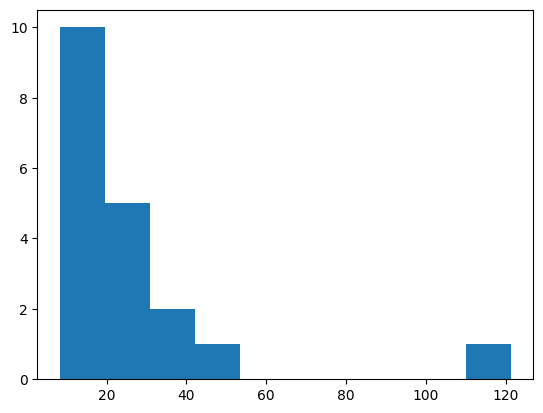

In [42]:
plt.hist(senescent_instensities)

In [5]:
for filenum in range(0, 1):

#for filenum in range(0, len(files)):
    clear_output(wait=True)
    filename = files[filenum][:-4]
    print("Loading filename: " + filename)
    im = AICSImage(raw_data_folder + os.path.sep + filename + '.czi')
    raw_im = im.data[0,:,:,:,:]

Loading filename: Image3_B


In [16]:
#measure the nuclei
matched_nuc_props = skimage.measure.regionprops(matching_nuclei)
measurement_im = np.amax(raw_im[1,:,:,:], axis=0)

matched_nuc_labels = []
senescent_instensities = []
non_senescent_intensities = []

for prop in matched_nuc_props:
    intensity = np.mean(measurement_im[matched_nuc_props == prop['label']])
    senescent_instensities.append(intensity)
    matched_nuc_labels.append(prop['label'])

for prop in all_nuc_props:
    if prop['label'] not in matched_nuc_labels:
        intensity = np.mean(measurement_im[nuc_labs == prop['label']])
        non_senescent_intensities.append(intensity)


NameError: name 'matching_nuclei' is not defined

In [ ]:
#make overlaid images

for i, file in tqdm(enumerate(files)):
    
    filename = file[:-4]
    im = AICSImage(raw_data_folder + os.path.sep + filename + '.czi')
    raw_im = im.data[0,:,:,:,:]
    classified_im = skimage.io.imread(outout_folder + os.path.sep + '2D_class' + os.path.sep + 'classified_' + filename + '.tif')
    nuclei_im = skimage.io.imread(outout_folder + os.path.sep + 'nuclei' + os.path.sep + filename + '.tif')
    classified_nuclei = skimage.io.imread(outout_folder + os.path.sep + 'matched_nuclei' + os.path.sep + filename + '_nuclei.tif')
    nuc_max = np.amax(raw_im[nuclei_channel,:,:,:], axis=0)
    scen_max = np.amax(raw_im[scen_channel,:,:,:], axis=0)
    classified_nuclei[classified_nuclei > 0] = 65535

    output = np.dstack((scen_max.astype(np.uint8), classified_nuclei.astype(np.uint8), nuc_max.astype(np.uint8)))
    #tifffile.imwrite(output_folder + os.path.sep + 'overlay' + os.path.sep + filename + "_rgb.tif", data=output, photometric='rgb', imagej=True)
    tifffile.imwrite(output_folder + os.path.sep + 'overlay' + os.path.sep + filename + ".tif", data=output, metadata={'mode': 'composite' 'axes': 'CYX'}, imagej=True)

In [342]:
#view the images

filenum = 5
filename = files[filenum][:-4]
print("Loading filename: " + filename)

im = AICSImage(raw_data_folder + os.path.sep + filename + '.czi')
raw_im = im.data[0,:,:,:,:]
classified_im = skimage.io.imread(outout_folder + os.path.sep + '2D_class' + os.path.sep + 'classified_' + filename + '.tif')
nuclei_im = skimage.io.imread(outout_folder + os.path.sep + 'nuclei' + os.path.sep + filename + '.tif')
classified_nuclei = skimage.io.imread(outout_folder + os.path.sep + 'matched_nuclei' + os.path.sep + filename + '_nuclei.tif')

viewer = napari.Viewer()
viewer.add_image(np.amax(raw_im[nuclei_channel,:,:,:], axis=0), colormap='green', blending='additive', name='nuclei')
viewer.add_image(np.amax(raw_im[scen_channel,:,:,:], axis=0), colormap='red', blending='additive', name='scenescent')  
viewer.add_labels(classified_im, name='scenescent mask')
viewer.add_labels(nuclei_im, name='all_nuclei')
viewer.add_labels(classified_nuclei, name='matched_nuclei')


Loading filename: Image2_B


<Labels layer 'matched_nuclei' at 0x7fcd2cd0d0a0>

In [307]:
viewer = napari.Viewer()
viewer.add_image(np.amax(raw_im[scen_channel,:,:,:], axis=0))
viewer.add_labels(filtered_lab_image)
viewer.add_labels(classified_im)
viewer.add_labels(matching_nuclei)
viewer.add_labels(nuclei_im)


<Labels layer 'nuclei_im' at 0x7fce713de4f0>